In [28]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [29]:
county = pd.read_csv("MMG_county_df_clean.csv")
county.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31419 entries, 0 to 31418
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Year                          31419 non-null  int64  
 1   FIPS                          31419 non-null  float64
 2   County                        31419 non-null  object 
 3   State                         31419 non-null  object 
 4   Food_Insecurity_Rate          31419 non-null  float64
 5   Num_Food_Insecure_Persons     31419 non-null  float64
 6   Low_Threshold_State           31419 non-null  float64
 7   Low_Threshold_Type            31419 non-null  object 
 8   High_Threshold_State          31419 non-null  float64
 9   High_Threshold_Type           31419 non-null  object 
 10  Pct_FI_Below_Low_Threshold    31419 non-null  float64
 11  Pct_FI_Between_Thresholds     26628 non-null  float64
 12  Pct_FI_Above_High_Threshold   31419 non-null  float64
 13  C

In [30]:
county.head(10)


,Year,FIPS,County,State,Food_Insecurity_Rate,Num_Food_Insecure_Persons,Low_Threshold_State,Low_Threshold_Type,High_Threshold_State,High_Threshold_Type,Pct_FI_Below_Low_Threshold,Pct_FI_Between_Thresholds,Pct_FI_Above_High_Threshold,Child_Food_Insecurity_Rate,Num_Food_Insecure_Children,Pct_FI_Children_Below_185FPL,Pct_FI_Children_Above_185FPL,Cost_Per_Meal,Annual_Food_Budget_Shortfall
0,2018,1001.0,autauga,AL,0.156,8620.0,1.3,SNAP,1.85,Other Nutrition Program,0.462,0.132,0.405,0.214,2870.0,0.69,0.31,3.33,4857000.0
1,2018,1003.0,baldwin,AL,0.129,26860.0,1.3,SNAP,1.85,Other Nutrition Program,0.371,0.187,0.442,0.169,7710.0,0.74,0.27,3.58,16274000.0
2,2018,1005.0,barbour,AL,0.219,5650.0,1.3,SNAP,1.85,Other Nutrition Program,0.651,0.108,0.241,0.32,1740.0,0.76,0.25,3.12,2988000.0
3,2018,1007.0,bibb,AL,0.151,3400.0,1.3,SNAP,1.85,Other Nutrition Program,0.469,0.212,0.319,0.209,970.0,0.92,0.08,2.94,1690000.0
4,2018,1009.0,blount,AL,0.136,7810.0,1.3,SNAP,1.85,Other Nutrition Program,0.429,0.279,0.292,0.191,2580.0,0.94,0.06,3.14,4149000.0
5,2018,1011.0,bullock,AL,0.205,2120.0,1.3,SNAP,1.85,Other Nutrition Program,0.749,0.003,0.247,0.324,700.0,0.52,0.48,3.32,1192000.0
6,2018,1013.0,butler,AL,0.191,3820.0,1.3,SNAP,1.85,Other Nutrition Program,0.669,0.130,0.201,0.27,1230.0,0.8,0.2,2.97,1917000.0
7,2018,1015.0,calhoun,AL,0.174,20050.0,1.3,SNAP,1.85,Other Nutrition Program,0.553,0.195,0.252,0.246,6210.0,0.87,0.13,2.98,10097000.0
8,2018,1017.0,chambers,AL,0.164,5530.0,1.3,SNAP,1.85,Other Nutrition Program,0.603,0.227,0.170,0.222,1560.0,0.86,0.14,2.92,2730000.0
9,2018,1019.0,cherokee,AL,0.156,4040.0,1.3,SNAP,1.85,Other Nutrition Program,0.487,0.311,0.202,0.211,1110.0,0.94,0.06,3.25,2221000.0


In [31]:
county["Food_Insecurity_Rate"].describe()

count    31419.000000
mean         0.145205
std          0.041776
min          0.024000
25%          0.117000
50%          0.141000
75%          0.168000
max          0.379000
Name: Food_Insecurity_Rate, dtype: float64

In [32]:
bins = [0, 0.117, 0.141, 0.168, 1]  # 1 is just a safe upper bound
labels = ["Low", "Moderate", "Elevated", "High"]

county["FI_Category"] = pd.cut(
    county["Food_Insecurity_Rate"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

county["FI_Category"].value_counts()

FI_Category
Low         8003
Moderate    7843
High        7801
Elevated    7772
Name: count, dtype: int64

### Step 1: Dropping Non-Predictive Columns

In [33]:
drop_cols = [
    "FIPS",
    "County",
    "State",
    "Year",
    "FI_Category"   # target
]

X = county.drop(columns=drop_cols)
y = county["FI_Category"]

### Step 2: Defining X & Y

In [34]:
X = county.drop(columns=drop_cols, errors='ignore')
y = county["FI_Category"]

### Step 3: One-Hot Encoding Categorical Columns

In [35]:
cat_cols = X.select_dtypes(include="object").columns.tolist()

X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

### Step 4: Train Test Split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [37]:
# using a smaller subset of the training data for tuning
X_train_small, _, y_train_small, _ = train_test_split(
    X_train,
    y_train,
    train_size=5000,          
    stratify=y_train,
    random_state=42
)

print(X_train_small.shape, y_train_small.shape)

(5000, 1876) (5000,)


### Step 5: Pipeline

In [38]:
from sklearn.impute import SimpleImputer

pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

### Step 6: Using GridSearchCV to Tune K

In [39]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "knn__n_neighbors": [3, 7, 11]   # small, reasonable set of k's
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=3,                             # fewer folds than 5
    scoring="balanced_accuracy",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_small, y_train_small)

print("Best params:", grid.best_params_)
print("Best CV balanced accuracy:", grid.best_score_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best params: {'knn__n_neighbors': 7}
Best CV balanced accuracy: 0.5063161095316061


### Step 7: Refitting Best Model on the Full Training Data

In [40]:
best_params = grid.best_params_

pipe.set_params(**best_params)
pipe.fit(X_train, y_train)

,steps,"[('imputer', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


### Step 8: Evaluating Model Performance on Test Data

In [41]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = pipe.predict(X_test)

test_acc = accuracy_score(y_test, y_pred)
print("Test accuracy:", test_acc)

print("\nClassification report:")
print(classification_report(y_test, y_pred))

print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))

Test accuracy: 0.5311903246339911

Classification report:
              precision    recall  f1-score   support

    Elevated       0.40      0.48      0.44      1554
        High       0.66      0.58      0.62      1560
         Low       0.69      0.65      0.67      1601
    Moderate       0.42      0.41      0.42      1569

    accuracy                           0.53      6284
   macro avg       0.54      0.53      0.53      6284
weighted avg       0.54      0.53      0.54      6284


Confusion matrix:
[[ 748  348   91  367]
 [ 470  902   33  155]
 [ 158   37 1038  368]
 [ 489   83  347  650]]


### Step 9: Comparing to a Baseline Model

In [42]:
majority_class = y_train.value_counts().idxmax()
baseline_pred = pd.Series(majority_class, index=y_test.index)

baseline_acc = accuracy_score(y_test, baseline_pred)
print("Baseline (majority class) accuracy:", baseline_acc)
print("Lift over baseline:", test_acc - baseline_acc)

Baseline (majority class) accuracy: 0.2547740292807129
Lift over baseline: 0.27641629535327816


### Step 10: Decision Regions in 2D 

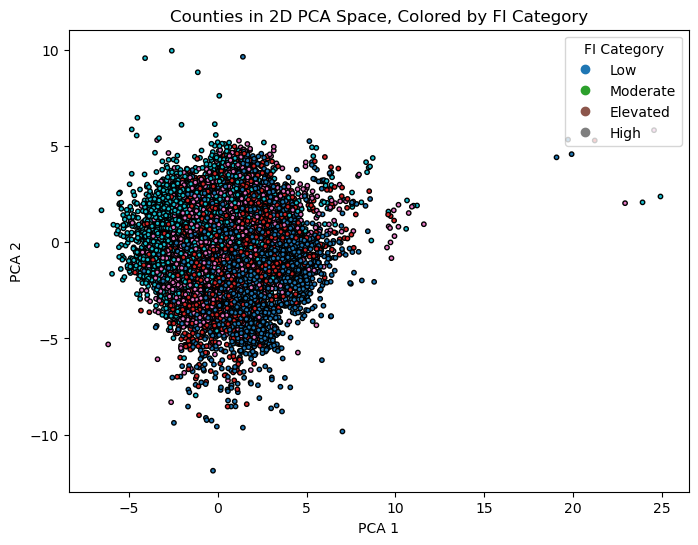

In [43]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# 1. Get imputed + scaled X_train from pipeline
X_train_proc = pipe.named_steps["scaler"].transform(
    pipe.named_steps["imputer"].transform(X_train)
)

# 2. PCA projection
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train_proc)

# 3. Encode FI categories
y_codes = y_train.astype("category").cat.codes.to_numpy()
categories = list(y_train.astype("category").cat.categories)

# 4. Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_train_2d[:, 0],
    X_train_2d[:, 1],
    c=y_codes,
    cmap="tab10",
    s=10,
    edgecolor="k"
)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Counties in 2D PCA Space, Colored by FI Category")

# 5. Add clean legend
handles = []
unique_codes = np.unique(y_codes)

for code in unique_codes:
    handles.append(
        plt.Line2D(
            [], [], 
            marker="o", 
            color=plt.cm.tab10(code / len(unique_codes)),
            linestyle="",
            label=categories[code]
        )
    )

plt.legend(
    handles=handles,
    title="FI Category",
    loc="upper right",
    frameon=True
)

plt.show()

### Step 11: Visualizing Neighbors of a Single County

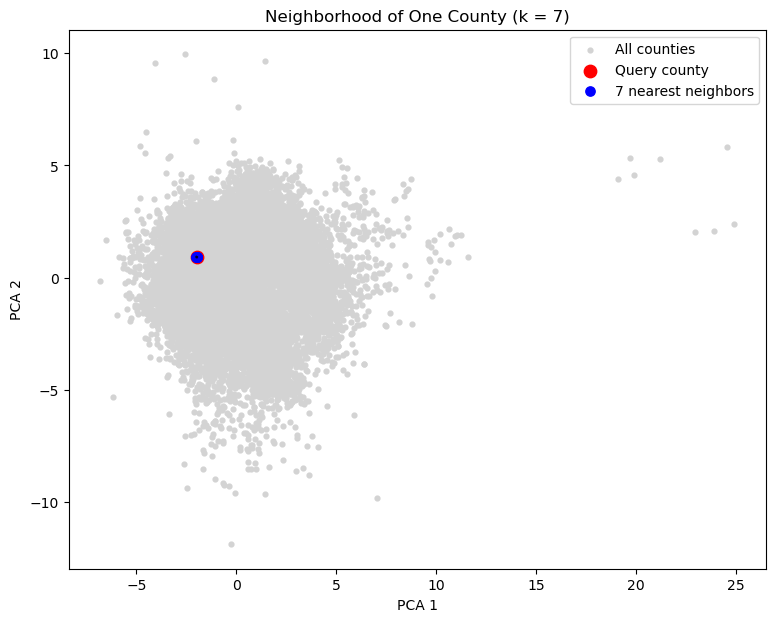

In [47]:
# 1. Pull the tuned k + weights from your fitted pipeline
best_k = pipe.named_steps["knn"].n_neighbors
best_weights = pipe.named_steps["knn"].weights

# 2. In PCA space, treat X_train_2d as already "scaled"
X_train_2d_scaled = X_train_2d

# 3. Fit a KNN model *in the 2D PCA space*
knn_2d = KNeighborsClassifier(
    n_neighbors=best_k,
    weights=best_weights
)
knn_2d.fit(X_train_2d_scaled, y_train)

# 4. Pick an index to visualize
idx = 3000  # choose any valid training row index

# 5. Find its nearest neighbors in PCA space
distances, indices = knn_2d.kneighbors(
    X_train_2d_scaled[idx].reshape(1, -1),
    n_neighbors=best_k
)
neighbors_idx = indices[0]

# 6. Plot everything
plt.figure(figsize=(9, 7))

# All points
plt.scatter(
    X_train_2d_scaled[:, 0],
    X_train_2d_scaled[:, 1],
    c="lightgray",
    s=12,
    label="All counties"
)

# Query county
plt.scatter(
    X_train_2d_scaled[idx, 0],
    X_train_2d_scaled[idx, 1],
    c="red",
    s=80,
    label="Query county"
)

# k nearest neighbors
plt.scatter(
    X_train_2d_scaled[neighbors_idx, 0],
    X_train_2d_scaled[neighbors_idx, 1],
    c="blue",
    s=45,
    label=f"{best_k} nearest neighbors"
)

# Lines from query to neighbors
for j in neighbors_idx:
    plt.plot(
        [X_train_2d_scaled[idx, 0], X_train_2d_scaled[j, 0]],
        [X_train_2d_scaled[idx, 1], X_train_2d_scaled[j, 1]],
        "k-", alpha=0.3
    )

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title(f"Neighborhood of One County (k = {best_k})")
plt.legend()
plt.show()

In [50]:
idx = 2000  # any row index

row = X.iloc[idx:idx+1]       # keep as dataframe
pred = pipe.predict(row)[0]

print("Predicted FI Category:", pred)

Predicted FI Category: Low


In [51]:
# Get prediction probabilities
probs = pipe.predict_proba(row)[0]
classes = pipe.named_steps["knn"].classes_

# Format into a clean dictionary
probs_dict = {cls: float(p) for cls, p in zip(classes, probs)}

print("Predicted FI Category:", pipe.predict(row)[0])
print("\nProbability Breakdown:")
for cls, p in probs_dict.items():
    print(f"  {cls:<10} -> {p:.3f}")

Predicted FI Category: Low

Probability Breakdown:
  Elevated   -> 0.143
  High       -> 0.000
  Low        -> 0.714
  Moderate   -> 0.143
